# Spatially-averaged fluxes
## Question: How does a heterogenous surface temperature impact grid-averaged fluxes? 

### Follow on to Mahrt 1987 "Grid-Averaged Surface Fluxes"

- Use the turbpy python package to answer this question in a synthetic study
- Prescribe Tsfc as two distinct populations following analysis of the IR camera images at Snoqualmie
- Assume that wind, water vapor, and air temperature are fairly constant across our "grid" 

##### How does the synthetic surface temperature impacts grid-averaged conductance, stability, and sensible heat flux?

### Hypothesis:
Heterogenous surface temperature is a pervasive feature in our observations. Spatial variability in surface temperature can drive large departures from the expected turbulence magnitude and sign due to the strongly non-linear conductance changes around neutral stability. We see this variability as an explanation for prevalent counter-gradient fluxes and the lack of a functional relationship between simulated and observed turbulent fluxes.

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('talk')
colr = kgraph.SRON(4)

# -------------------------------------------------------------------------------------------------------
# Directory Lists
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirData = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'

### Prescribe parameters


In [3]:
# -------------------------------------------------------------------------------------------------------
# turbpy arguments
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
z0Ground = .005

# -------------------------------------------------------------------------------------------------------
# meteorological variables
airTemp = 283
windspd = 1.0
mHeight = 2.
snowDepth = 0
scalarGroundSnowFraction  = 0
airPressure = 101000.



In [4]:
# -------------------------------------------------------------------------------------------------------
# Surface temperature as a double gaussian
sfcTempMean1 = 271 # Mean snow temperature right below freezing
sfcTempMean2 = 283 # Mean tree temperature well above freezing, equal to air temperature
sfcTempSigma1 = 1 
sfcTempSigma2 = 1

# Double gaussian probability
c1 = 1
c2 = 1
x = np.arange(261, 291, .1)
sfcTempProb = c1 \
              * np.exp( - (x - sfcTempMean1)**2.0 / (2.0 * sfcTempSigma1**2.0) ) \
              + c2 \
              * np.exp( - (x - sfcTempMean2)**2.0 / (2.0 * sfcTempSigma2**2.0) )


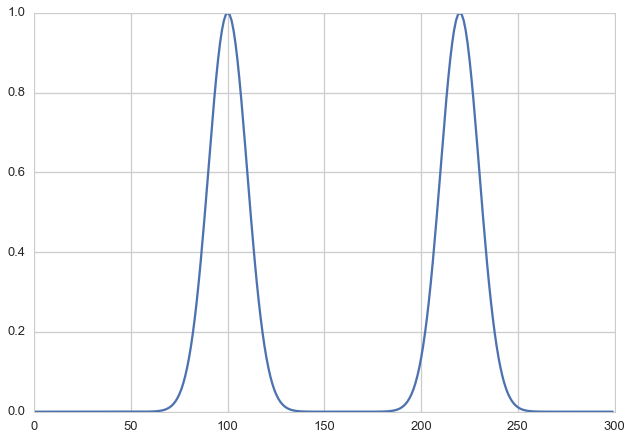

In [5]:
plt.plot(sfcTempProb)

## Vary meteorological variables

### Tair variability
- small ($\sigma = $ 1K)
- large ($\sigma = $ 10K)

### Wind variability
- single scenario ($\sigma = $ 1 m/s)

### Temperature gradient
- vary linearly from -10K to +10K

Skewed distributions area a little hard to make. Check out:
    - https://en.wikipedia.org/wiki/Generalized_normal_distribution
    - http://stackoverflow.com/questions/10814363/apply-kurtosis-to-a-distribution-in-python
    - http://stackoverflow.com/questions/19604389/how-to-generate-a-distribution-with-a-given-mean-variance-skew-and-kurtosis-in

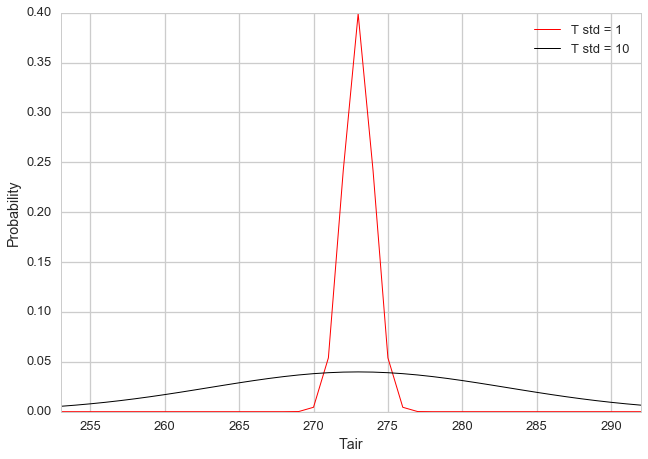

In [3]:
numSamples = 1000 
smallVar = 1
largeVar = 10
airTemp_smallVar = np.random.normal(airTemp_mean, smallVar, numSamples)
airTemp_largeVar = np.random.normal(airTemp_mean, largeVar, numSamples)

RiBulk_smallVar,_,_ = turbpy.bulkRichardson(airTemp_smallVar,sfcTemp,windspd,mHeight)
RiBulk_largeVar,_,_ = turbpy.bulkRichardson(airTemp_largeVar,sfcTemp,windspd,mHeight)

import matplotlib.mlab as mlab
fig, ax = plt.subplots(1,1)
bins = np.arange(airTemp_mean-20,airTemp_mean+20)
y = mlab.normpdf( bins, airTemp_mean, smallVar)
ax.plot(bins, y, 'r', linewidth=1, label='T std = 1')
y = mlab.normpdf( bins, airTemp_mean, largeVar)
ax.plot(bins, y, 'k', linewidth=1, label='T std = 10')
ax.legend()
ax.set_xlim(min(bins),max(bins))
ax.set_xlabel('Tair')
ax.set_ylabel('Probability')

### How does Ri behave with the synthetic dataset?

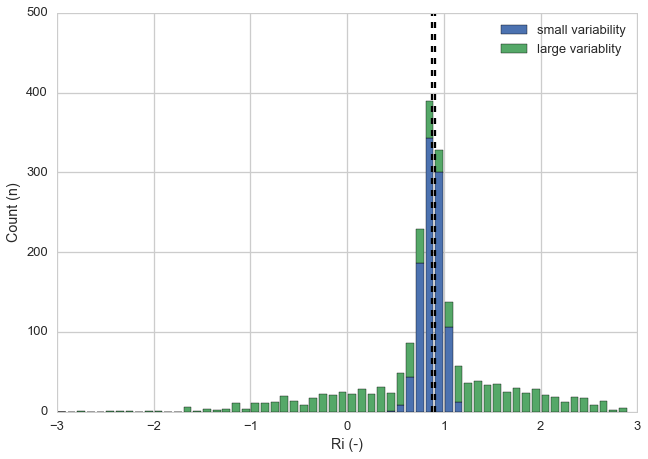

In [4]:
fig, ax = plt.subplots(1,1)
ax.hist([RiBulk_smallVar, RiBulk_largeVar], bins=np.arange(-3,3,.1),
        stacked=True, label=['small variability','large variablity']);
ax.plot([np.mean(RiBulk_smallVar),np.mean(RiBulk_smallVar)],[0,500],'k--')
ax.plot([np.mean(RiBulk_largeVar),np.mean(RiBulk_largeVar)],[0,500],'k--')
ax.legend()
ax.set_xlabel('Ri (-)')
ax.set_ylabel('Count (n)')

## Stability and related parameters

In [5]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
stability_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }
conductanceSensible_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }
conductanceLatent_smallVar = {
    ixStability[0]:np.zeros_like(airTemp_smallVar),
    ixStability[1]:np.zeros_like(airTemp_smallVar),
    ixStability[2]:np.zeros_like(airTemp_smallVar),
    ixStability[3]:np.zeros_like(airTemp_smallVar),
    }

for stab in ixStability:
    for n,tair in enumerate(airTemp_smallVar):
        (_,stabOutput,_,
         conductanceSensible_smallVar[stab][n],
         conductanceLatent_smallVar[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               airVaporPress, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stability_smallVar[stab][n] = stabOutput['stabilityCorrection']
            
# -------------------------------------------------------------------------------------------------------
# large temperature variability
# -------------------------------------------------------------------------------------------------------
stability_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }
conductanceSensible_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }
conductanceLatent_largeVar = {
    ixStability[0]:np.zeros_like(airTemp_largeVar),
    ixStability[1]:np.zeros_like(airTemp_largeVar),
    ixStability[2]:np.zeros_like(airTemp_largeVar),
    ixStability[3]:np.zeros_like(airTemp_largeVar),
    }

for stab in ixStability:
    for n,tair in enumerate(airTemp_largeVar):
        (_,stabOutput,_,
         conductanceSensible_largeVar[stab][n],
         conductanceLatent_largeVar[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               airVaporPress, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stability_largeVar[stab][n] = stabOutput['stabilityCorrection']

## Fluxes

In [6]:
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_largeVar = xray.Dataset()
latent_largeVar = xray.Dataset()

for stab in ixStability:
    senHeatGround = np.ones_like(airTemp_largeVar)*np.nan
    latHeatGround = np.ones_like(airTemp_largeVar)*np.nan
    
    for n,tair in enumerate(airTemp_largeVar):
        # Offline turbulence
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )

    sensible_largeVar[stab] = (('n'),senHeatGround)
    latent_largeVar[stab] = (('n'),latHeatGround)
    
# -------------------------------------------------------------------------------------------------------
# small temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_smallVar = xray.Dataset()
latent_smallVar = xray.Dataset()

for stab in ixStability:
    senHeatGround = np.ones_like(airTemp_smallVar)*np.nan       # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.ones_like(airTemp_smallVar)*np.nan       # latent heat flux from ground surface (W m-2)
    
    for n,tair in enumerate(airTemp_smallVar):
        # Offline turbulence
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )

    sensible_smallVar[stab] = (('n'),senHeatGround)
    latent_smallVar[stab] = (('n'),latHeatGround)

# Figures
## Stability Corrections

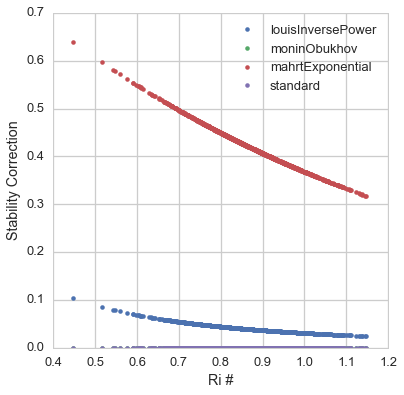

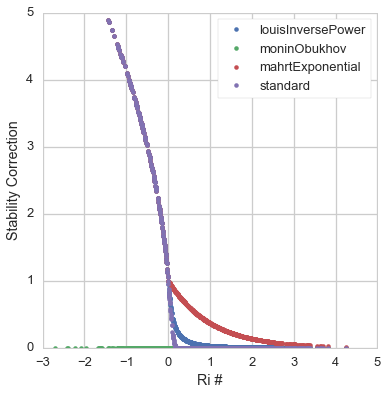

In [7]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stability_smallVar:
    ax.plot(RiBulk_smallVar,stability_smallVar[stab],'.',label=stab)
ax.legend(loc='best')
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stability_largeVar:
    ax.plot(RiBulk_largeVar,stability_largeVar[stab],'.',label=stab)
ax.legend(loc='best',frameon=True)
ax.set_ylim(0,5)
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

### Conductance

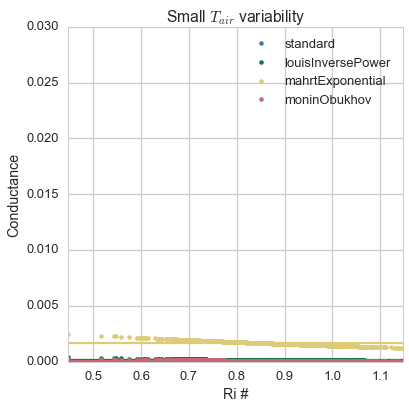

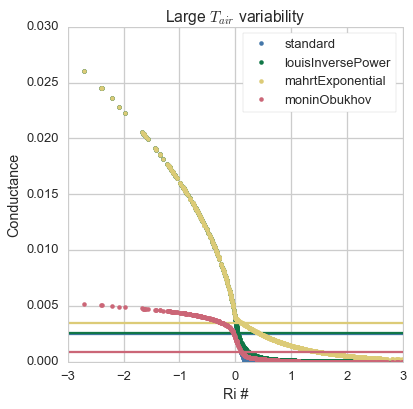

In [45]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_smallVar, conductanceSensible_smallVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
        [np.mean(conductanceSensible_smallVar[stab]), np.mean(conductanceSensible_smallVar[stab])],
        color=colr[n])
ax.set_xlim(min(RiBulk_smallVar),max(RiBulk_smallVar))
ax.set_ylim(0,0.03)
ax.legend(loc='best')
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Small $T_{air}$ variability')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_largeVar, conductanceSensible_largeVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
            [np.mean(conductanceSensible_largeVar[stab]), np.mean(conductanceSensible_largeVar[stab])],
            color=colr[n])
ax.set_xlim(-3,3)
ax.set_ylim(0,0.03)
ax.legend(loc='best',frameon=True)
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Large $T_{air}$ variability')

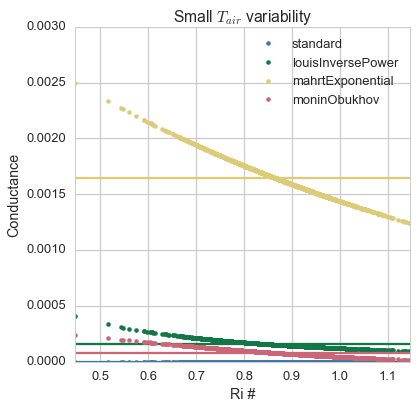

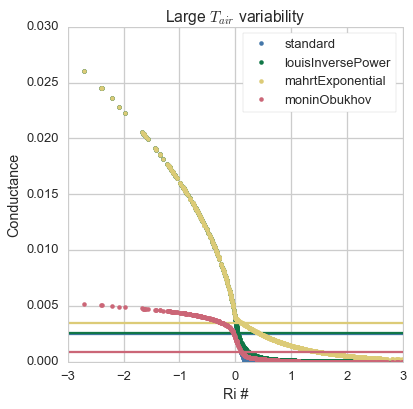

In [9]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_smallVar, conductanceSensible_smallVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
        [np.mean(conductanceSensible_smallVar[stab]), np.mean(conductanceSensible_smallVar[stab])],
        color=colr[n])
ax.set_xlim(min(RiBulk_smallVar),max(RiBulk_smallVar))
ax.legend(loc='best')
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Small $T_{air}$ variability')

fig,ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk_largeVar, conductanceSensible_largeVar[stab], '.', label=stab, color=colr[n])
    ax.plot([-3, 3],
            [np.mean(conductanceSensible_largeVar[stab]), np.mean(conductanceSensible_largeVar[stab])],
            color=colr[n])
ax.set_xlim(-3,3)
ax.legend(loc='best',frameon=True)
ax.set_ylabel('Conductance')
ax.set_xlabel('Ri #')
ax.set_title('Large $T_{air}$ variability')

## Fluxes
### PDF/Histogram distributions

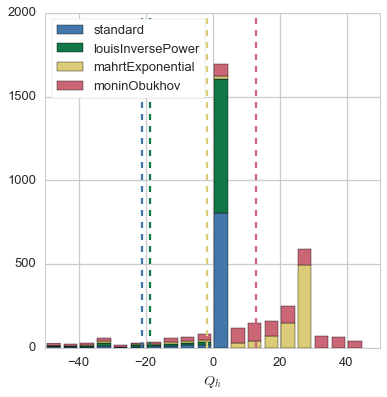

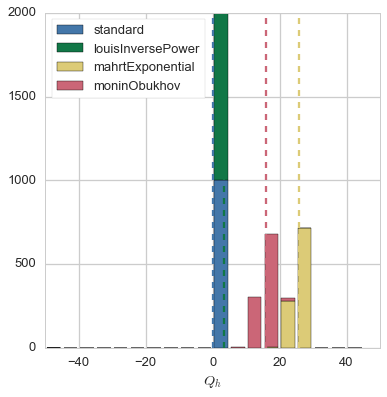

In [10]:
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([sensible_largeVar.standard, sensible_largeVar.louisInversePower,\
        sensible_largeVar.mahrtExponential, sensible_largeVar.moninObukhov], \
        bins=np.arange(-50,50,5), stacked=True, color = colr, label = ixStability);
for n,stab in enumerate(ixStability):
    ax.plot([sensible_largeVar[stab].mean(dim='n'), sensible_largeVar[stab].mean(dim='n')], [0, 2000],\
            '--', color=colr[n])
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-50,50)
ax.set_xlabel('$Q_h$')

# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([sensible_smallVar.standard, sensible_smallVar.louisInversePower,
        sensible_smallVar.mahrtExponential, sensible_smallVar.moninObukhov],
        bins=np.arange(-50,50,5), stacked=True, color=colr, label=ixStability);
for n,stab in enumerate(ixStability):
    ax.plot([sensible_smallVar[stab].mean(dim='n'), sensible_smallVar[stab].mean(dim='n')], [0, 2000],\
            '--', color=colr[n])
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-50,50)
ax.set_xlabel('$Q_h$')

### CDFs

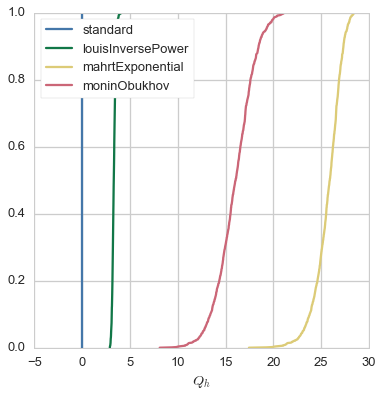

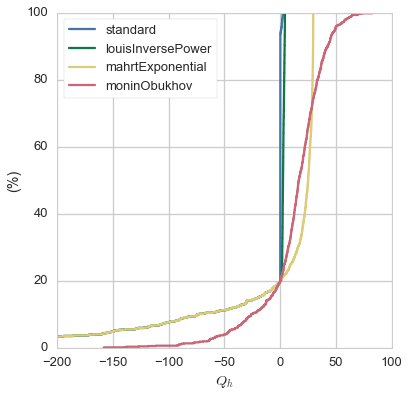

In [11]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(sensible_smallVar[stab])
    ax.plot(sorted_data, np.arange(sorted_data.size) / float(numSamples), color=colr[n], label=stab)
ax.legend(loc='upper left',frameon=True)
ax.set_xlim(-5,30)
ax.set_xlabel('$Q_h$')

# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(sensible_largeVar[stab])
    ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100, color=colr[n], label=stab)
ax.legend(loc='upper left',frameon=True)
ax.set_ylabel('(%)')
ax.set_xlim(-200,100)
ax.set_xlabel('$Q_h$')

### What drives the weird behavior of the CDF, $\Delta T$ or $C_h$?

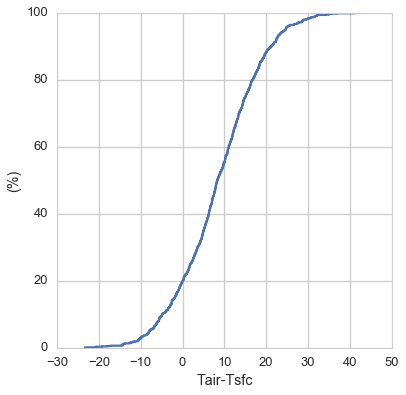

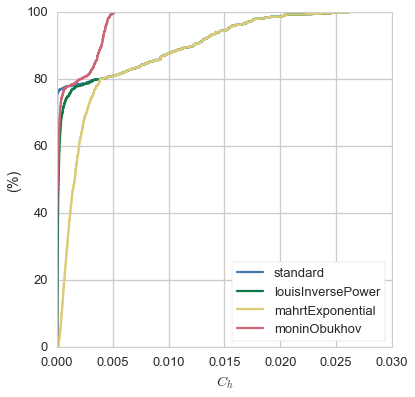

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
# Cumulative distributions:
sorted_data = np.sort(airTemp_largeVar - sfcTemp)
ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100)
ax.set_ylabel('(%)')
ax.set_xlabel('Tair-Tsfc')

fig, ax = plt.subplots(1,1,figsize=(6,6))
for n,stab in enumerate(ixStability):
    # Cumulative distributions:
    sorted_data = np.sort(conductanceSensible_largeVar[stab])
    ax.step(sorted_data, np.arange(sorted_data.size) / float(numSamples) * 100, color=colr[n], label=stab)
ax.legend(loc='lower right',frameon=True)
ax.set_ylabel('(%)')
ax.set_xlabel('$C_h$')

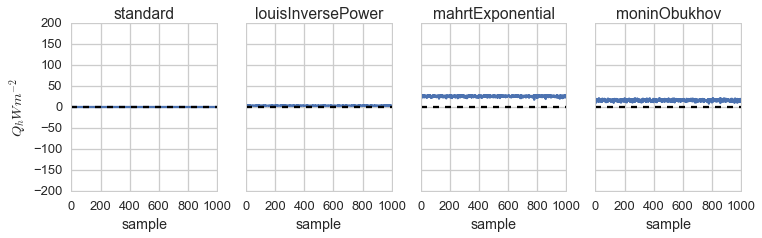

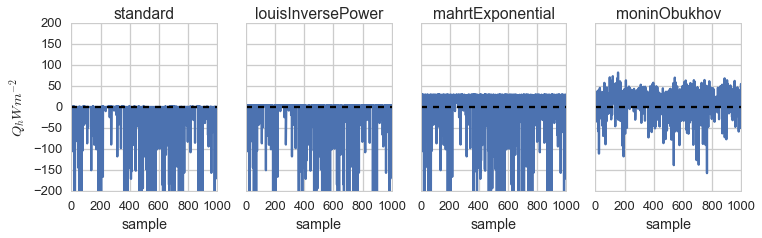

In [13]:
# -------------------------------------------------------------------------------------------------------
# Small temperature variability
# -------------------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
axes = axes.flatten()
for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(sensible_smallVar[stab])
    ax.plot([0,sensible_smallVar.n.max()],[0,0],'k--')
    ax.set_xlabel('sample')
    if n == 0:
        ax.set_ylabel('$Q_h Wm^{-2}$')
    ax.set_title(stab)
    ax.set_ylim(-200,200)
    
# -------------------------------------------------------------------------------------------------------
# Large temperature variability
# -------------------------------------------------------------------------------------------------------
fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
axes = axes.flatten()
for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(sensible_largeVar[stab])
    ax.plot([0,sensible_largeVar.n.max()],[0,0],'k--')
    ax.set_xlabel('sample')
    if n == 0:
        ax.set_ylabel('$Q_h Wm^{-2}$')
    ax.set_title(stab)
    ax.set_ylim(-200,200)

## $Q_h$ as a function of std($T_{air}$)

In [14]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_var = np.arange(1,11)
sensMean = np.zeros((10,4))

for istab,stab in enumerate(ixStability):
    for istd,tair_std in enumerate(airTemp_var):
        airTemp_rand = np.random.normal(airTemp_mean, tair_std, numSamples)
        senHeatGround = np.ones(numSamples)*np.nan

        for n,tair in enumerate(airTemp_rand):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[istd,istab] = np.mean(senHeatGround)


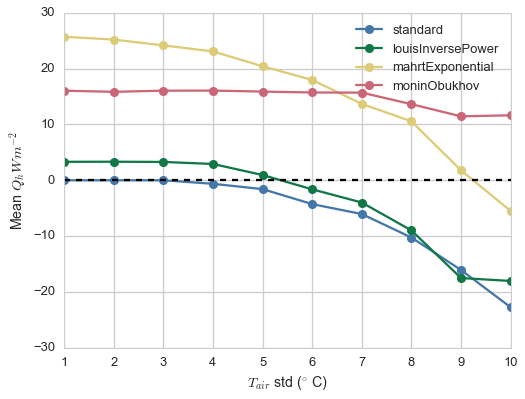

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(airTemp_var,sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([1,10],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('$T_{air}$ std ($^{\circ}$ C)')
ax.legend()

## $Q_h$ as a function of mean wind speed

In [16]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
sensMean = np.zeros((10,4))
windspd_mean = np.arange(.5,5.5,.5)

for istab,stab in enumerate(ixStability):
    for nWindMean,WindMean in enumerate(windspd_mean):
        senHeatGround = np.ones(numSamples)*np.nan
        
        for n,tair in enumerate(airTemp_largeVar):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, WindMean, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[nWindMean,istab] = np.nanmean(senHeatGround)


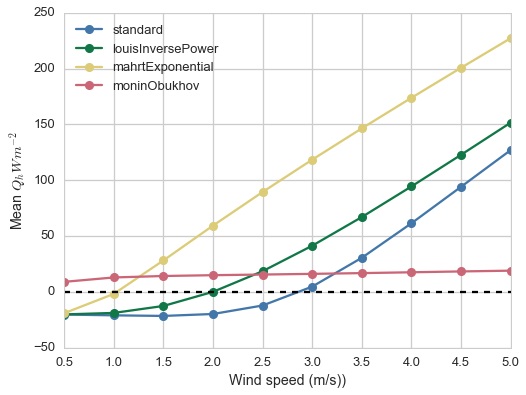

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(windspd_mean,sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([min(windspd_mean),max(windspd_mean)],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('Wind speed (m/s))')
ax.legend(loc='upper left')

In [18]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_mean = np.arange(253,293)
airTemp_var = 10
sensMean = np.zeros((airTemp_mean.size,4))

for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        airTemp_rand = np.random.normal(tair_mean, airTemp_var, numSamples)
        senHeatGround = np.ones(numSamples)*np.nan

        for n,tair in enumerate(airTemp_rand):
            # Offline turbulence
            (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
        sensMean[imean, istab] = np.mean(senHeatGround)


(-12.0, 27.0)

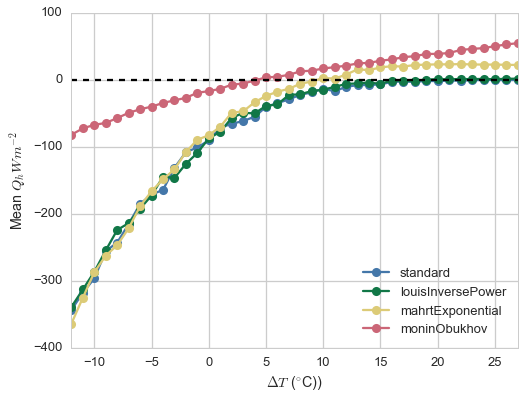

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for istab,stab in enumerate(ixStability):
    ax.plot(airTemp_mean -sfcTemp, sensMean[:,istab],'-o',color=colr[istab],label=stab)

ax.plot([min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp],[0,0],'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('$\Delta T$ ($^{\circ}$C))')
ax.legend(loc='lower right')
ax.set_xlim(min(airTemp_mean)-sfcTemp,max(airTemp_mean)-sfcTemp)

In [41]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_mean = np.arange(sfcTemp - 15, sfcTemp + 15)
airTemp_var = np.arange(1,11)
sensMean = np.zeros((airTemp_mean.size,airTemp_var.size,4))

for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        for istd, tair_std in enumerate(airTemp_var):
            airTemp_rand = np.random.normal(tair_mean, tair_std, numSamples)
            senHeatGround = np.ones(numSamples)*np.nan

            for n,tair in enumerate(airTemp_rand):
                # Offline turbulence
                (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                    tair, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                    groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                    )
            sensMean[imean, istd, istab] = np.mean(senHeatGround)


In [42]:
# Remove non-noisy signal from just varyint delta-T
sensMean_nonoise = np.zeros((airTemp_mean.size,4))
sensMean_justnoise = np.zeros((airTemp_mean.size,airTemp_var.size,4))
for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        senHeatGround = np.nan
        # Offline turbulence
        (_, _, senHeatGround, _, _, _, _, _) = turbpy.turbFluxes(
            tair_mean, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )
        sensMean_nonoise[imean, istab] = senHeatGround
        sensMean_justnoise[imean, :, istab] = sensMean[imean, :, istab] - sensMean_nonoise[imean, istab]


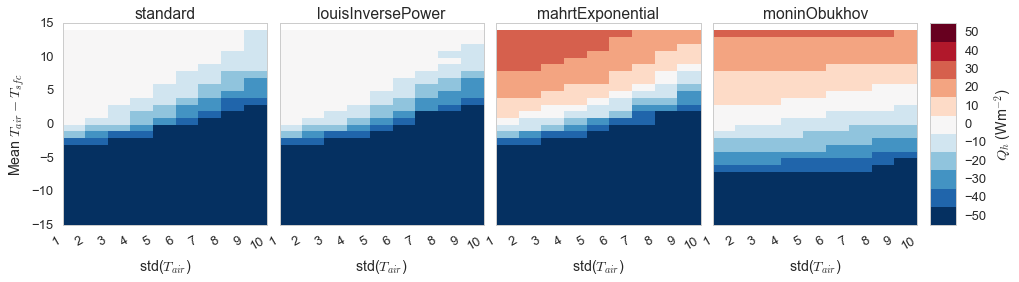

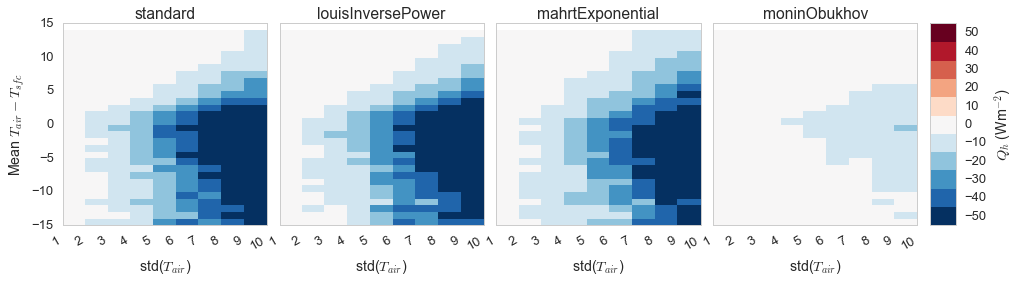

In [43]:
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r,11)

# -------------------------------------------------------------------------------------------------------
# Surface plot of Qh
# -------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,4))
gs = matplotlib.gridspec.GridSpec(1,5,\
                                  width_ratios=np.array((8,8,8,8,1)))
gs.update(wspace=0.075)

for istab,stab in enumerate(ixStability):
    ax = plt.subplot(gs[istab])
    im = ax.pcolor(airTemp_var, airTemp_mean - sfcTemp, sensMean[:,:,istab], cmap=cmap_delta, vmin=-55, vmax=55)
    ax.set_title(stab)
    if istab == 0:
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('std($T_{air}$)')
    
# Colorbar - monthly values
caxi=plt.subplot(gs[-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",\
                    ticks=np.arange(-50,50+10,10),spacing='proportional')
cbar.ax.set_ylabel(('$Q_h$ (Wm$^{-2}$)'))
fig.autofmt_xdate()
    
# -------------------------------------------------------------------------------------------------------
# Surface plot of Qh w/ Noise - Qh w/out Noise
# -------------------------------------------------------------------------------------------------------   
fig = plt.figure(figsize=(16,4))
gs = matplotlib.gridspec.GridSpec(1,5,\
                                  width_ratios=np.array((8,8,8,8,1)))
gs.update(wspace=0.075)
for istab,stab in enumerate(ixStability):
    ax = plt.subplot(gs[istab])
    im = ax.pcolor(airTemp_var, airTemp_mean - sfcTemp, sensMean_justnoise[:,:,istab],
                   cmap=cmap_delta, vmin=-55, vmax=55)
    ax.set_title(stab)
    if istab == 0:
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('std($T_{air}$)')

# Colorbar - monthly values
caxi=plt.subplot(gs[-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",\
                    ticks=np.arange(-50,50+10,10),spacing='proportional')
cbar.ax.set_ylabel(('$Q_h$ (Wm$^{-2}$)'))
fig.autofmt_xdate()


# Further directions

### Variable unstable  parameterizations

Currently turbpy only includes a single conductance parameterization for unstable conditions for the bulk aerodynamic methods. No ability to switch unstable conductance parameterizations, e.g., limits on free convection from the SNTHERM MOST method.

Current Bulk Aero. unstable stability:

$ S = (1 - 16Ri_B)^{1/2} $

From Louis 1979 (eq 4):

$ S = 1- \frac{b Ri_B}{1+c(Ri_B)^{1/2}}$

$b = 2b' = 9.4$

(c = ?)

- notation varies substantially between sources. Need to follow equations through/perform dimensional analysis to verify that each represents the same quantity.

### Introduce variability in $T_{sfc}$

Surface temperature may vary more over short spatial scales than it does in time. However, since turbulent fluxes integrate over a spatial source, this may amount to a similar effect as variaility in time (a la the Mahrt 1987 paper)

Image of $T_{sfc}$ at Snoqualmie in the morning yields a spatial variability of .8-1 $^{\circ}$C

### Varying Wind strength

In [38]:
sensible_var = xray.Dataset()
latent_var = xray.Dataset()
airTemp_mean = np.arange(sfcTemp - 15, sfcTemp + 15)
airTemp_var = np.arange(1,11)
sfcTemp_var = .8
sensMean = np.zeros((airTemp_mean.size,airTemp_var.size,4))

for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        for istd, tair_std in enumerate(airTemp_var):
            airTemp_rand = np.random.normal(tair_mean, tair_std, numSamples)
            sfcTemp_rand = np.random.normal(sfcTemp, sfcTemp_var, numSamples)
            senHeatGround = np.ones(numSamples)*np.nan

            for n,(tair,tsfc) in enumerate(zip(airTemp_rand, sfcTemp_rand)):
                # Offline turbulence
                (_, _, senHeatGround[n], _, _, _, _, _) = turbpy.turbFluxes(
                    tair, 101000, airVaporPress, windspd, tsfc, sfcVaporPress, snowDepth, mHeight,
                    groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                    )
            sensMean[imean, istd, istab] = np.mean(senHeatGround)


In [39]:
# Remove non-noisy signal from just varyint delta-T
sensMean_nonoise = np.zeros((airTemp_mean.size,4))
sensMean_justnoise = np.zeros((airTemp_mean.size,airTemp_var.size,4))
for istab,stab in enumerate(ixStability):
    for imean, tair_mean in enumerate(airTemp_mean):
        senHeatGround = np.nan
        # Offline turbulence
        (_, _, senHeatGround, _, _, _, _, _) = turbpy.turbFluxes(
            tair_mean, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixStability=stab, z0Ground=.005,
            )
        sensMean_nonoise[imean, istab] = senHeatGround
        sensMean_justnoise[imean, :, istab] = sensMean[imean, :, istab] - sensMean_nonoise[imean, istab]


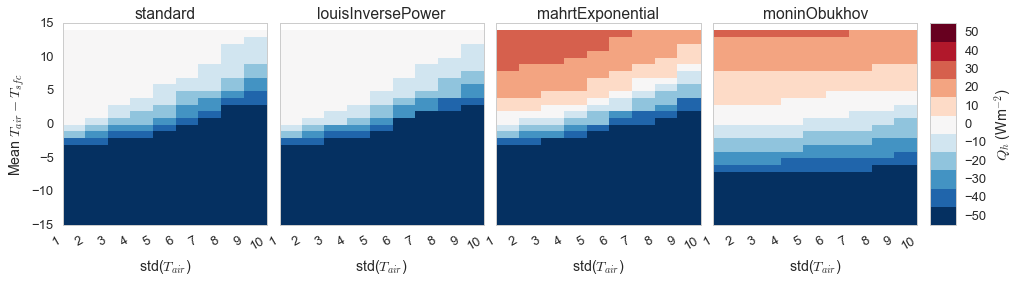

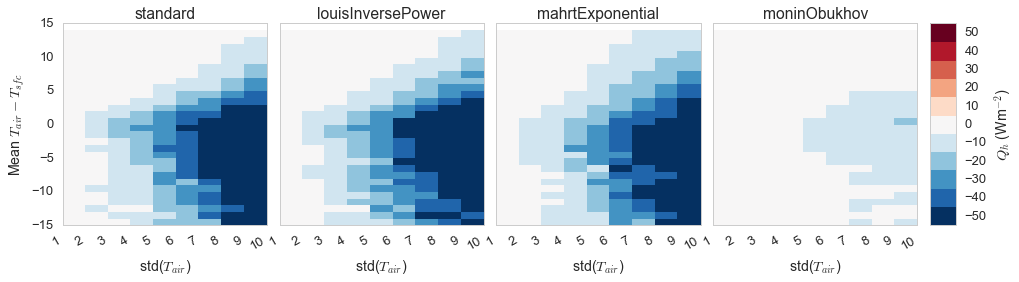

In [40]:
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r,11)

# -------------------------------------------------------------------------------------------------------
# Surface plot of Qh
# -------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,4))
gs = matplotlib.gridspec.GridSpec(1,5,\
                                  width_ratios=np.array((8,8,8,8,1)))
gs.update(wspace=0.075)

for istab,stab in enumerate(ixStability):
    ax = plt.subplot(gs[istab])
    im = ax.pcolor(airTemp_var, airTemp_mean - sfcTemp, sensMean[:,:,istab], cmap=cmap_delta, vmin=-55, vmax=55)
    ax.set_title(stab)
    if istab == 0:
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('std($T_{air}$)')
    
# Colorbar - monthly values
caxi=plt.subplot(gs[-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",\
                    ticks=np.arange(-50,50+10,10),spacing='proportional')
cbar.ax.set_ylabel(('$Q_h$ (Wm$^{-2}$)'))
fig.autofmt_xdate()
    
# -------------------------------------------------------------------------------------------------------
# Surface plot of Qh w/ Noise - Qh w/out Noise
# -------------------------------------------------------------------------------------------------------   
fig = plt.figure(figsize=(16,4))
gs = matplotlib.gridspec.GridSpec(1,5,\
                                  width_ratios=np.array((8,8,8,8,1)))
gs.update(wspace=0.075)
for istab,stab in enumerate(ixStability):
    ax = plt.subplot(gs[istab])
    im = ax.pcolor(airTemp_var, airTemp_mean - sfcTemp, sensMean_justnoise[:,:,istab],
                   cmap=cmap_delta, vmin=-55, vmax=55)
    ax.set_title(stab)
    if istab == 0:
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
        ax.set_ylabel('Mean $T_{air} - T_{sfc}$')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('std($T_{air}$)')

# Colorbar - monthly values
caxi=plt.subplot(gs[-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",\
                    ticks=np.arange(-50,50+10,10),spacing='proportional')
cbar.ax.set_ylabel(('$Q_h$ (Wm$^{-2}$)'))
fig.autofmt_xdate()
